# `causalml` Examples: Using Uplift Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain
from sklearn.model_selection import train_test_split

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
plt.style.use("ggplot")

## Generate synthetic dataset

In [3]:
df, x_names = make_uplift_classification()

In [4]:
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


In [5]:
x_names

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_irrelevant',
 'x7_irrelevant',
 'x8_irrelevant',
 'x9_irrelevant',
 'x10_irrelevant',
 'x11_uplift_increase',
 'x12_uplift_increase',
 'x13_increase_mix',
 'x14_uplift_increase',
 'x15_uplift_increase',
 'x16_increase_mix',
 'x17_uplift_increase',
 'x18_uplift_increase',
 'x19_increase_mix']

In [6]:
df.pivot_table(values="conversion",
               index="treatment_group_key",
               aggfunc=[np.mean, np.std, np.size],
               margins=True)

,mean,std,size
,conversion,conversion,conversion
treatment_group_key,,,
control,0.511,0.500129,1000
treatment1,0.514,0.500054,1000
treatment2,0.559,0.496755,1000
treatment3,0.600,0.490143,1000
All,0.546,0.497880,4000


## Run the uplift random forest classifier

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [30]:
uplift_model = UpliftRandomForestClassifier(control_name="control", n_estimators=100)

In [31]:
uplift_model.fit(df_train[x_names].values, 
                 treatment=df_train['treatment_group_key'].values, 
                 y=df_train['conversion'].values)

In [32]:
y_pred = uplift_model.predict(df_test[x_names].values)

In [33]:
result = pd.DataFrame(y_pred, columns=uplift_model.classes_)
result.head()

,treatment1,treatment2,treatment3
0,-0.027921,0.139499,0.000472
1,0.060424,0.171008,0.025079
2,0.012292,0.054555,0.031833
3,-0.040997,-0.056588,-0.030456
4,-0.014395,-0.025419,-0.003693


## Create the uplift curve

In [21]:
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1), "control", result.idxmax(axis=1))

In [36]:
# Create indicator variables for whether a unit happened to have the recommended treatment or was in the control group
actual_is_best = np.where(df_test['treatment_group_key'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['treatment_group_key'] == 'control', 1, 0)

In [45]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

In [56]:
auuc_metrics = synth.assign(is_treated=1 - actual_is_control[synthetic],
                             conversion=df_test.loc[synthetic, 'conversion'].values,
                             uplift_tree=synth.max(axis=1))
auuc_metrics = auuc_metrics.drop(columns=list(uplift_model.classes_))

In [57]:
auuc_metrics.head()

,is_treated,conversion,uplift_tree
2,0,1,0.054555
3,0,1,-0.030456
7,1,1,0.178344
9,0,1,0.051680
11,1,1,0.013061


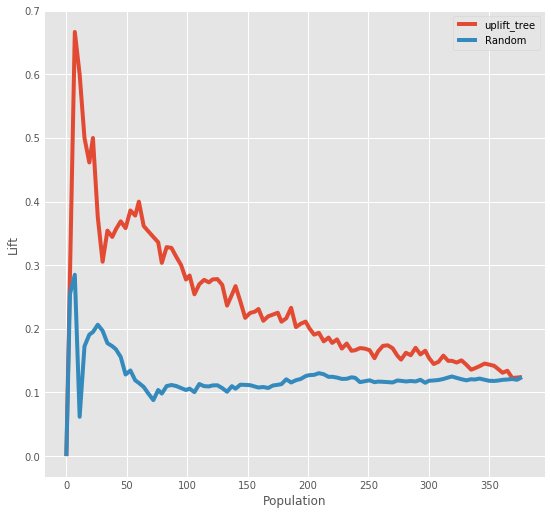

In [58]:
causalml.metrics.plot_lift(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

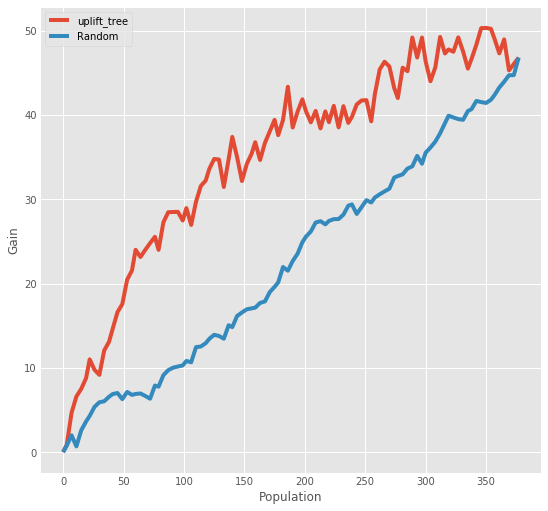

In [59]:
causalml.metrics.plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')